In [40]:

import os
import math
import numpy as np
import xarray as xr
from PIL import Image

# Constants for Web Mercator projection
TILE_SIZE = 256
INITIAL_RESOLUTION = 2 * math.pi * 6378137 / TILE_SIZE
ORIGIN_SHIFT = 2 * math.pi * 6378137 / 2.0

def latlon_to_meters(lat, lon):
    mx = lon * ORIGIN_SHIFT / 180.0
    my = math.log(math.tan((90 + lat) * math.pi / 360.0)) * 6378137
    return mx, my

def meters_to_pixels(mx, my, zoom):
    res = INITIAL_RESOLUTION / (2 ** zoom)
    px = (mx + ORIGIN_SHIFT) / res
    py = (ORIGIN_SHIFT - my) / res
    return int(px), int(py)

def pixels_to_tile(px, py):
    tx = int(px / TILE_SIZE)
    ty = int(py / TILE_SIZE)
    return tx, ty

def save_tile(tile_data, output_dir, z, x, y, ti):
    os.makedirs(os.path.join(output_dir,str(ti), str(z), str(x)), exist_ok=True)
    tile_path = os.path.join(output_dir, str(ti), str(z), str(x), f"{y}.png")
    img = Image.fromarray(tile_data)
    img.save(tile_path)

def generate_tiles(netcdf_file, variable, output_dir="tiles", zoom_levels=range(0, 3)):
    ds = xr.open_dataset(netcdf_file)
    data = ds[variable].values
    lats = ds['latitude'].values
    lons = ds['longitude'].values

    for z in zoom_levels:
        print(f"Generating tiles for zoom level {z}...")
        for ti in range(len(ds['time'].values)):
            for i in range(len(lats)):
                for j in range(len(lons)):
                    lat = lats[i]
                    lon = lons[j]
                    value = data[ti,i, j]
                    #fill NaN values with 0 in the data
                    if np.isnan(value):
                        value = 0
                    

                    mx, my = latlon_to_meters(lat, lon)
                    px, py = meters_to_pixels(mx, my, z)
                    tx, ty = pixels_to_tile(px, py)

                    # Create a simple grayscale tile with the value
                    tile_data = np.full((TILE_SIZE, TILE_SIZE), int(value) % 256, dtype=np.uint8)
                    save_tile(tile_data, output_dir, z, tx, ty, ti)

    print("Tile generation complete.")


In [41]:

generate_tiles('../data/NSea/SOL_predictions_2024-04-18.nc', 'SOL_fishing_suitability')

Generating tiles for zoom level 0...
Generating tiles for zoom level 1...
Generating tiles for zoom level 2...
Tile generation complete.


In [32]:
import xarray as xr
d = xr.load_dataset('../data/NSea/SOL_predictions_2024-04-18.nc')

#iterate through time dimension
for time in d['time']:
    print(time.values)
d['time'][0]
d

2024-04-18T00:00:00.000000000
2024-04-19T00:00:00.000000000
2024-04-20T00:00:00.000000000
2024-04-21T00:00:00.000000000
2024-04-22T00:00:00.000000000


<xarray.Dataset> Size: 9MB
Dimensions:                  (longitude: 675, latitude: 689, time: 5)
Coordinates:
  * longitude                (longitude) float64 5kB -15.0 -14.96 ... 9.963
  * latitude                 (latitude) float64 6kB 61.29 61.27 ... 46.02 46.0
  * time                     (time) datetime64[ns] 40B 2024-04-18 ... 2024-04-22
Data variables:
    SOL_fishing_suitability  (time, latitude, longitude) float32 9MB 34.19 .....
    crs                      int32 4B -2147483647
Attributes:
    Conventions:  CF-1.4
    created_by:   R packages ncdf4 and terra (version 1.7-71)
    date:         2024-04-18 15:51:22

In [20]:

# Extract the data for the specified tile
tile_data = sol.sel(latitude=slice(t.top, t.bottom), longitude=slice(t.left, t.right))
# Print the shape of the extracted tile data
print(tile_data.shape)
# Plot the extracted tile data  

(5, 689, 675)


In [21]:
t

Bbox(left=-20037508.342789244, bottom=-20037508.342789244, right=20037508.342789244, top=20037508.342789244)

TypeError: Invalid shape (5, 689, 675) for image data

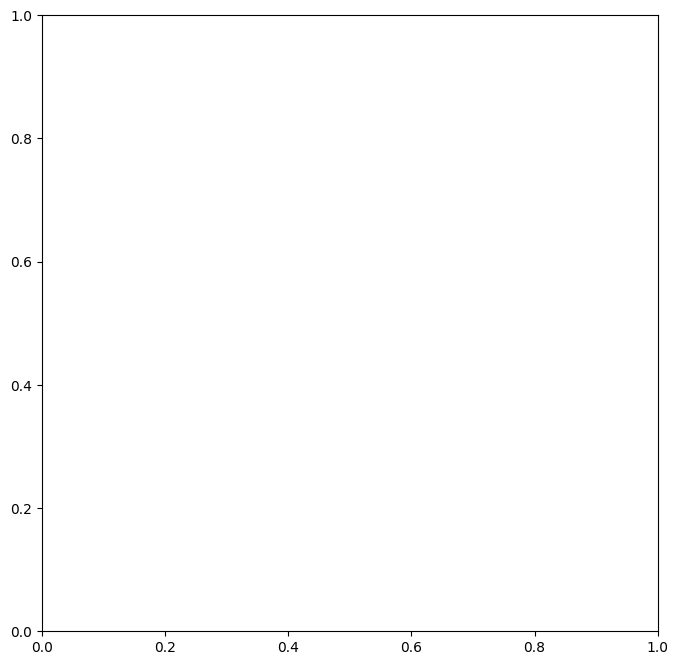

In [18]:
#pregenerate all the tiles for all the zoom levels
def plot_tile(tile_data, tile):
    plt.figure(figsize=(8, 8))
    plt.imshow(tile_data, extent=(tile.left, tile.right, tile.bottom, tile.top), origin='upper', cmap='viridis')
    plt.colorbar(label='Fishing Suitability')
    plt.title(f'Tile {tile.x}, {tile.y}, Zoom {tile.z}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
# Plot the tile data
plot_tile(tile_data, t)
# Save the plot to a file
plt.savefig(f'tile_{tile.x}_{tile.y}_zoom_{tile.z}.png')


In [15]:
#generate all tiles for all zoom levels
def generate_tiles(ds, zoom_levels):
    for zoom in zoom_levels:
        for x in range(2**zoom):
            for y in range(2**zoom):
                tile = mercantile.Tile(x=x, y=y, z=zoom)
                t = mercantile.xy_bounds(tile)
                tile_data = ds.sel(latitude=slice(t.top, t.bottom), longitude=slice(t.left, t.right))
                plot_tile(tile_data, tile)
                plt.savefig(f'tile_{tile.x}_{tile.y}_zoom_{tile.z}.png')
                plt.close()
# Define the zoom levels to generate tiles for
zoom_levels = range(0, 5)  # Adjust the range as needed
# Generate tiles for the specified zoom levels
generate_tiles(sol, zoom_levels)
# Note: The above code will generate a lot of plots and save them to files.
# You can adjust the zoom_levels range to limit the number of tiles generated.
# Clean up the dataset
ds.close()
# Close the dataset to free up resources
# Note: The above code will generate a lot of plots and save them to files.
# You can adjust the zoom_levels range to limit the number of tiles generated.

NameError: name 'plot_tile' is not defined